<a href="https://colab.research.google.com/github/Abdullah-Al-Roman/research-paper/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]


Training mBERT...
Epoch 1:
Average Training Loss: 1.3363
Average Validation Loss: 1.1479
New best model saved!

Epoch 2:
Average Training Loss: 1.0341
Average Validation Loss: 1.0588
New best model saved!

Epoch 3:
Average Training Loss: 0.8498
Average Validation Loss: 1.0453
New best model saved!

Epoch 4:
Average Training Loss: 0.6938
Average Validation Loss: 1.1074
Epoch 5:
Average Training Loss: 0.5480
Average Validation Loss: 1.1883
Epoch 6:
Average Training Loss: 0.4248
Average Validation Loss: 1.2674
Epoch 7:
Average Training Loss: 0.3265
Average Validation Loss: 1.2624
Epoch 8:
Average Training Loss: 0.2437
Average Validation Loss: 1.4868
Epoch 9:
Average Training Loss: 0.2025
Average Validation Loss: 1.5964
Epoch 10:
Average Training Loss: 0.1744
Average Validation Loss: 1.5834
Epoch 11:
Average Training Loss: 0.1529
Average Validation Loss: 1.7052
Epoch 12:
Average Training Loss: 0.1371
Average Validation Loss: 1.7498
Epoch 13:
Average Training Loss: 0.1268
Average Validatio

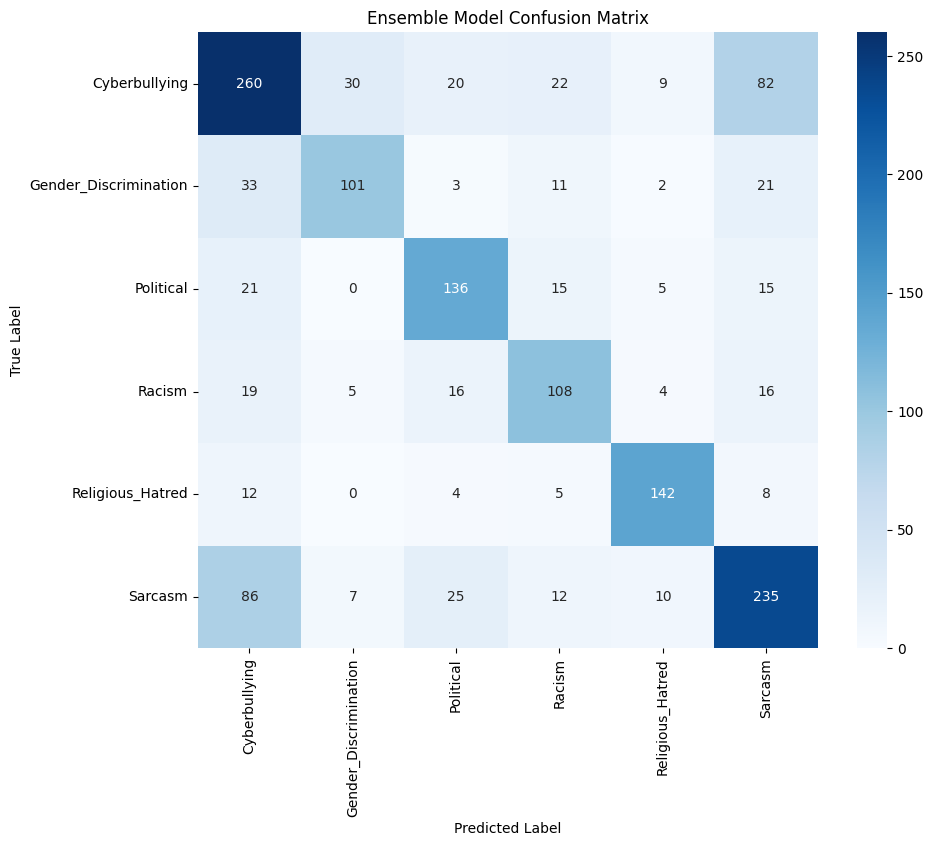

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, matthews_corrcoef
import torch
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BertTokenizer,
    BertForSequenceClassification,
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForSequenceClassification
)
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

class EnsembleModel:
    def __init__(self, num_labels):
        # Initialize all models
        self.mbert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=num_labels)
        self.xlmr = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=num_labels)
        self.distilbert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=num_labels)
        self.bangla_bert = AutoModelForSequenceClassification.from_pretrained('sagorsarker/bangla-bert-base', num_labels=num_labels)

        # Initialize tokenizers
        self.mbert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
        self.distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
        self.bangla_bert_tokenizer = AutoTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

        # Move models to device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.mbert.to(self.device)
        self.xlmr.to(self.device)
        self.distilbert.to(self.device)
        self.bangla_bert.to(self.device)

    def tokenize_text(self, text, tokenizer, max_length=128):
        return tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

    def get_probabilities(self, model, encodings):
        model.eval()
        with torch.no_grad():
            outputs = model(
                input_ids=encodings['input_ids'].to(self.device),
                attention_mask=encodings['attention_mask'].to(self.device)
            )
            probs = F.softmax(outputs.logits, dim=-1)
        return probs.cpu()

    def predict_proba(self, texts):
        # Get probabilities from each model
        mbert_encodings = self.tokenize_text(texts, self.mbert_tokenizer)
        xlmr_encodings = self.tokenize_text(texts, self.xlmr_tokenizer)
        distilbert_encodings = self.tokenize_text(texts, self.distilbert_tokenizer)
        bangla_bert_encodings = self.tokenize_text(texts, self.bangla_bert_tokenizer)

        # Get probabilities
        mbert_probs = self.get_probabilities(self.mbert, mbert_encodings)
        xlmr_probs = self.get_probabilities(self.xlmr, xlmr_encodings)
        distilbert_probs = self.get_probabilities(self.distilbert, distilbert_encodings)
        bangla_bert_probs = self.get_probabilities(self.bangla_bert, bangla_bert_encodings)

        # Average probabilities
        avg_probs = (mbert_probs + xlmr_probs + distilbert_probs + bangla_bert_probs) / 4
        return avg_probs

    def predict(self, texts):
        avg_probs = self.predict_proba(texts)
        return torch.argmax(avg_probs, dim=1)

def train_individual_model(model, tokenizer, train_data, train_labels, val_data, val_labels, model_name, device):
    print(f"\nTraining {model_name}...")

    # Tokenize data
    train_encodings = tokenizer(
        train_data.tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    val_encodings = tokenizer(
        val_data.tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    # Convert labels to tensors
    train_labels_tensor = torch.tensor(train_labels.values)
    val_labels_tensor = torch.tensor(val_labels.values)

    # Create datasets
    train_dataset = TensorDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        train_labels_tensor
    )
    val_dataset = TensorDataset(
        val_encodings['input_ids'],
        val_encodings['attention_mask'],
        val_labels_tensor
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Training settings
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    best_val_loss = float('inf')
    best_model_state = None

    # Training loop
    for epoch in range(16):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += outputs.loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        print(f'Epoch {epoch + 1}:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            print(f'New best model saved!\n')

    # Load best model
    model.load_state_dict(best_model_state)
    return model

# Function to compute Geometric Mean Score (G-Score)
def compute_gmean(conf_matrix):
    # Extract true positives, false positives, true negatives, false negatives
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis=0) - tp
    fn = np.sum(conf_matrix, axis=1) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # Sensitivity (Recall) and Specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Geometric Mean Score (G-Score)
    gmean = np.sqrt(sensitivity * specificity)
    return np.mean(gmean)

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    df = pd.read_csv('/content/merged (1).csv')

    # Encode labels
    label_encoder = LabelEncoder()
    df['labels'] = label_encoder.fit_transform(df['labels'])

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        df['text'],
        df['labels'],
        test_size=0.3,
        random_state=42,
        stratify=df['labels']
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    # Initialize ensemble
    ensemble = EnsembleModel(num_labels=len(label_encoder.classes_))
    device = ensemble.device

    # Train individual models
    ensemble.mbert = train_individual_model(
        ensemble.mbert, ensemble.mbert_tokenizer,
        X_train, y_train, X_val, y_val, "mBERT", device
    )

    ensemble.xlmr = train_individual_model(
        ensemble.xlmr, ensemble.xlmr_tokenizer,
        X_train, y_train, X_val, y_val, "XLM-R", device
    )

    ensemble.distilbert = train_individual_model(
        ensemble.distilbert, ensemble.distilbert_tokenizer,
        X_train, y_train, X_val, y_val, "DistilBERT", device
    )

    ensemble.bangla_bert = train_individual_model(
        ensemble.bangla_bert, ensemble.bangla_bert_tokenizer,
        X_train, y_train, X_val, y_val, "Bangla-BERT", device
    )

    # Evaluate ensemble
    print("\nEvaluating ensemble...")
    predictions = ensemble.predict(X_test.tolist())
    predictions = predictions.numpy()

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, predictions)
    test_precision = precision_score(y_test, predictions, average='weighted')
    test_recall = recall_score(y_test, predictions, average='weighted')
    test_f1 = f1_score(y_test, predictions, average='weighted')
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions,
                                       target_names=label_encoder.classes_)

    # Calculate G-Score and MCC
    test_mcc = matthews_corrcoef(y_test, predictions)
    test_gmean = compute_gmean(conf_matrix)

    # Print results
    print("\nFinal Ensemble Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"MCC: {test_mcc:.4f}")
    print(f"G-Score: {test_gmean:.4f}")

    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Ensemble Model Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Save results
    with open('ensemble_results.txt', 'w', encoding='utf-8') as f:
        f.write("Ensemble Model Results\n")
        f.write("====================\n\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        f.write(f"Test Precision: {test_precision:.4f}\n")
        f.write(f"Test Recall: {test_recall:.4f}\n")
        f.write(f"Test F1 Score: {test_f1:.4f}\n\n")
        f.write(f"Test MCC: {test_mcc:.4f}\n")
        f.write(f"Test G-Score: {test_gmean:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(class_report)
